In [6]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'brain-tumor:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1454010%2F2404385%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240731%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240731T060552Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Daf600576958ccecccb1f87d71735c623ece873ede077875f9abb8deb40add3098797af0fcc5e88e2ab6c96c041f7dddb8e0f3a57f11366bb8aa4771e393ab9aeb828e067ab0f6db23090878998a45f0a8bfdb21ed1ce3c7ac207c0c2ea654b67eb9ca111db55c13a993204b0a7245c8e690d439a54341b0d3e220ac79c665f39356e79141e3426ed05d85ecf5d4d7cfa35d97b6d3ee60112c28235c0abde0cfea680af481004cccb85ce8fd5d6617f94fdeb84e70b2047db9f657790f44df7ae520a18f108030480beb4be2e264befdd591edde09ad9c0ff48277a62c5bd5a83719b06300b981829962c7b6f10428e3fee00ef8256ab57f42f39a158b353a672'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 733590913 bytes downloaded
Downloaded and uncompressed: brain-tumor
Data source import complete.


# Libraries and Configurations

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
import glob, random, os, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print('TensorFlow Version ' + tf.__version__)

def seed_everything(seed = 0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything()

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


TensorFlow Version 2.15.0


In [5]:
!pip install tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [8]:
image_size = 224
batch_size = 16
n_classes = 3
EPOCHS = 30

train_path = '/kaggle/input/brain-tumor'

classes = {1 : "Meningioma",
           2 : "Glioma",
           3 : "Pituitary Tumor"}

In [9]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)

    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    if p_spatial > .75:
        image = tf.image.transpose(image)

    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º

    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)

    return image

# Data Generator

In [10]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                          validation_split = 0.2,
                                                          preprocessing_function = data_augment)
# set as training data

train_gen  = datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size = batch_size,
    seed = 1,
    color_mode = 'rgb',
    shuffle = True,
    class_mode='categorical',
    subset='training')

# same directory as training data

valid_gen  = datagen.flow_from_directory(
    train_path ,
    target_size=(224, 224),
    batch_size = batch_size,
    seed = 1,
    color_mode = 'rgb',
    shuffle = False,
    class_mode='categorical',
    subset='validation')

Found 2452 images belonging to 3 classes.
Found 612 images belonging to 3 classes.


# Sample Image Visualization

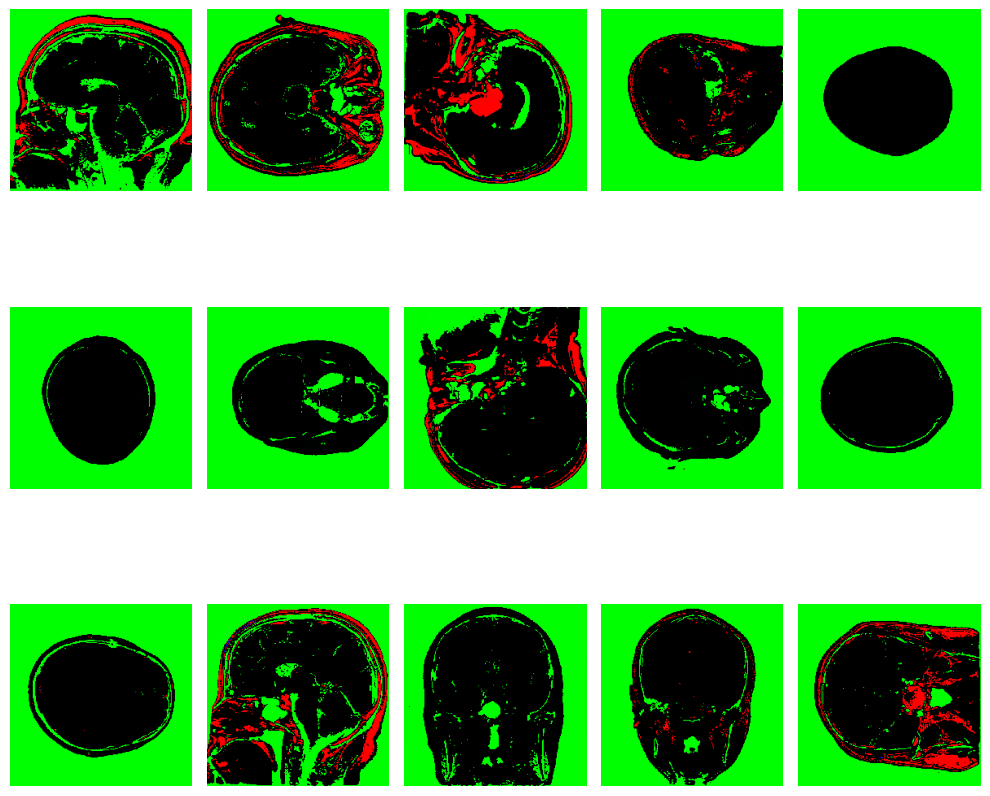

In [11]:
warnings.filterwarnings("ignore")

images = [train_gen[0][0][i] for i in range(16)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))

axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(image_size, image_size, 3).astype("uint8"))
    ax.axis('off')

plt.tight_layout()
plt.show()

# Building the Model

In [12]:
!pip install vit_keras

# 1 - ViT B16 Model

In [13]:
from vit_keras import vit

vit_model = vit.vit_b16(
        image_size = image_size,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 5)

In [14]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

## Visualizing Attention Maps of Sample Test Image

Image size: 224 X 224
Patch size: 7 X 7
Patches per image: 1024
Elements per patch: 147


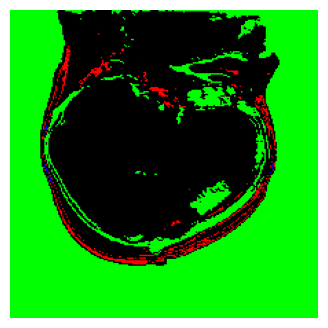

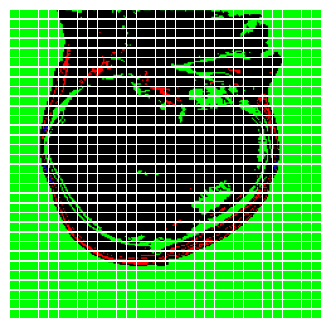

In [15]:
plt.figure(figsize=(4, 4))
batch_size = 16
patch_size = 7  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2

x = train_gen.next()
image = x[0][0]

plt.imshow(image.astype('uint8'))
plt.axis('off')

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')

## ViT Model Architecture

In [16]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(32, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(3, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (Batch  (None, 768)               3072      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 64)         

## Training the Model

In [ ]:
warnings.filterwarnings("ignore")

learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size



early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True, verbose = 1)

model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = early_stopping_callbacks)

Epoch 1/30
  6/153 [>.............................] - ETA: 1:34:43 - loss: 1.2714 - accuracy: 0.3333

In [ ]:

model.save('model.h5')

## ViT Model Result

In [ ]:
predicted_classes = np.argmax(model.predict(valid_gen, steps = valid_gen.n // valid_gen.batch_size + 1), axis = 1)
true_classes = valid_gen.classes
class_labels = list(valid_gen.class_indices.keys())

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_classes, predicted_classes))

# 2 - ResNet50

In [ ]:
model2 = tf.keras.Sequential()

base1= tf.keras.applications.ResNet50V2(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=3,
                   weights='imagenet')

model2.add(base1)

model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Dense(128, activation = tfa.activations.gelu))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Dense(64, activation = tfa.activations.gelu))
model2.add(tf.keras.layers.Dense(32, activation = tfa.activations.gelu))
model2.add(tf.keras.layers.Dense(3, 'softmax'))

for layer in base1.layers:
    layer.trainable = False

model2.summary()

## Training The Model

In [ ]:
model2.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
              metrics = ['accuracy'])

history = model2.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = early_stopping_callbacks)

## Model Result

In [ ]:
predicted_classes = np.argmax(model2.predict(valid_gen, steps = valid_gen.n // valid_gen.batch_size + 1), axis = 1)
true_classes = valid_gen.classes
class_labels = list(valid_gen.class_indices.keys())

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_classes, predicted_classes))

## 3 - VGG19

In [ ]:
model3 = tf.keras.Sequential()

base2= tf.keras.applications.VGG19(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=3,
                   weights='imagenet')

model3.add(base2)

model3.add(tf.keras.layers.Flatten())
model3.add(tf.keras.layers.BatchNormalization())
model3.add(tf.keras.layers.Dense(128, activation = tfa.activations.gelu))
model3.add(tf.keras.layers.BatchNormalization())
model3.add(tf.keras.layers.Dense(64, activation = tfa.activations.gelu))
model3.add(tf.keras.layers.Dense(32, activation = tfa.activations.gelu))
model3.add(tf.keras.layers.Dense(3, 'softmax'))

for layer in base2.layers:
    layer.trainable = False

model3.summary()

## Training The Model

In [ ]:
model3.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
              metrics = ['accuracy'])

history = model3.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = early_stopping_callbacks)

## Model Result

In [ ]:
predicted_classes = np.argmax(model3.predict(valid_gen, steps = valid_gen.n // valid_gen.batch_size + 1), axis = 1)
true_classes = valid_gen.classes
class_labels = list(valid_gen.class_indices.keys())

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_classes, predicted_classes))

# 4 - InceptionV3

In [ ]:
model4 = tf.keras.Sequential()

base3= tf.keras.applications.inception_v3.InceptionV3(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',
                   classes=3,
                   weights='imagenet')

model4.add(base3)

model4.add(tf.keras.layers.Flatten())
model4.add(tf.keras.layers.BatchNormalization())
model4.add(tf.keras.layers.Dense(128, activation = tfa.activations.gelu))
model4.add(tf.keras.layers.BatchNormalization())
model4.add(tf.keras.layers.Dense(64, activation = tfa.activations.gelu))
model4.add(tf.keras.layers.Dense(32, activation = tfa.activations.gelu))
model4.add(tf.keras.layers.Dense(3, 'softmax'))

for layer in base3.layers:
    layer.trainable = False

model4.summary()

## Training The Model

In [ ]:
model4.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
              metrics = ['accuracy'])

history = model4.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = early_stopping_callbacks)

## Model Result

In [ ]:
predicted_classes = np.argmax(model4.predict(valid_gen, steps = valid_gen.n // valid_gen.batch_size + 1), axis = 1)
true_classes = valid_gen.classes
class_labels = list(valid_gen.class_indices.keys())

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_classes, predicted_classes))